<a href="https://colab.research.google.com/github/lsqroger/stock-forecast-TS-LSTM/blob/main/stock_forecast_LSTM(multi_step).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=1dbdbb972cd9ed0c138d180d4d87495231eba08ad2cbca7002f259baa2150608
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
### Define parameters
select_ticker = 'MSFT'
select_date = '2021-10-11'
hist_win = 2      # years

# For LSTM:
fcst_horizon = 7  # days
time_steps = 14   # days
n_features = 1 

In [5]:
### Retrieve Data of selected ticker and date
stock = yf.Ticker(select_ticker)
history = stock.history(period='Max')
meta_cols = history.columns
history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-07,295.179993,296.640015,293.920013,294.850006,20430500,0.0,0.0
2021-10-08,296.220001,296.640015,293.760010,294.850006,17680300,0.0,0.0
2021-10-11,292.920013,297.970001,292.750000,294.230011,19298600,0.0,0.0
2021-10-12,295.339996,295.440002,292.350006,292.880005,17974100,0.0,0.0
2021-10-13,294.910004,297.279999,293.489990,296.309998,23416300,0.0,0.0


In [6]:
### Pre-process and prepare train dataset
# Filter based on seleceted date
df_train_val = history.reset_index(drop=False).astype({'Date':'datetime64'})
date_thres = pd.to_datetime(select_date) - pd.DateOffset(years=hist_win)
df_train_val = df_train_val.loc[(df_train_val.Date >= date_thres)&(df_train_val.Date <= select_date)]

# Normalization of Close Price time series
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(np.array(df_train_val.Close).reshape(-1, 1))
df_train_val['scaled_close'] = scaled_close

df_train_val.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,scaled_close
8465,2019-10-11,137.283068,138.174648,136.675626,136.851974,25446000,0.0,0.0,0.019558
8466,2019-10-14,136.861759,137.449602,136.695203,136.724594,13304300,0.0,0.0,0.018816
8467,2019-10-15,137.224252,138.919222,136.979314,138.703690,19695700,0.0,0.0,0.030341
8468,2019-10-16,137.939465,138.135428,136.704981,137.567169,20751600,0.0,0.0,0.023723
8469,2019-10-17,138.096255,138.556740,136.205338,136.861771,21460600,0.0,0.0,0.019615


In [7]:
### Prepare output time series with n-day horizon
df_train_val.sort_values('Date', ascending=True, inplace=True)

output_df = pd.DataFrame()
for i in range(df_train_val.shape[0]):
  t_series = df_train_val.iloc[i:i+fcst_horizon,:]
  t_min_date = t_series.Date.min()
  t_series = list(t_series.scaled_close)
  if len(t_series) < fcst_horizon:
    break
  t_df = pd.DataFrame({
      'Date': t_min_date,
      'output_ts': [t_series]
  })
  output_df = pd.concat([output_df, t_df], axis=0)

df_train_val = df_train_val.merge(output_df, on='Date', how='left')

In [11]:
df_train_val.dropna(subset=['output_ts'], axis=0, inplace=True)
df_train_val.tail(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,scaled_close,output_ts
488,2021-09-20,296.329987,298.720001,289.519989,294.299988,38278700,0.0,0.0,0.936411,"[0.9364105090320742, 0.9393221121811337, 0.961..."
489,2021-09-21,295.690002,297.540009,294.070007,294.799988,22364100,0.0,0.0,0.939322,"[0.9393221121811337, 0.961333824879617, 0.9670..."
490,2021-09-22,296.730011,300.220001,294.510010,298.579987,26626300,0.0,0.0,0.961334,"[0.961333824879617, 0.9670406310274287, 0.9658..."
491,2021-09-23,298.850006,300.899994,297.529999,299.559998,18604600,0.0,0.0,0.967041,"[0.9670406310274287, 0.9658178074636665, 0.935..."
492,2021-09-24,298.230011,299.799988,296.929993,299.350006,14999000,0.0,0.0,0.965818,"[0.9658178074636665, 0.9356536414898473, 0.873..."
493,2021-09-27,296.140015,296.470001,292.940002,294.170013,23571700,0.0,0.0,0.935654,"[0.9356536414898473, 0.8736363522467585, 0.876..."
494,2021-09-28,289.799988,290.779999,282.750000,283.519989,43186200,0.0,0.0,0.873636,"[0.8736363522467585, 0.8764315552455106, 0.864..."
495,2021-09-29,285.100006,286.769989,283.010010,284.000000,26353700,0.0,0.0,0.876432,"[0.8764315552455106, 0.8643193643378906, 0.906..."
496,2021-09-30,285.709991,287.829987,281.619995,281.920013,32325800,0.0,0.0,0.864319,"[0.8643193643378906, 0.9061299429079477, 0.871..."
497,2021-10-01,282.119995,289.980011,281.290009,289.100006,30086300,0.0,0.0,0.906130,"[0.9061299429079477, 0.8712488163393113, 0.904..."


In [49]:
### Build LSTM ts input and output data for multi-step forecasting
input_data = np.array(df_train_val.scaled_close).reshape(len(df_train_val.scaled_close),n_features)
#output_data = np.array(df_train_val.output_ts.apply(lambda x: np.array(x))).reshape(len(df_train_val.output_ts),n_features)
output_data = np.stack(df_train_val.output_ts)

ts_generator = TimeseriesGenerator(input_data, output_data, length=time_steps, batch_size=1)

In [62]:
X,y = ts_generator[0]
print(X[0])
print(y[0])
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

[[0.01955825]
 [0.01881648]
 [0.03034117]
 [0.02372297]
 [0.01961529]
 [0.006607  ]
 [0.01242647]
 [0.00067352]
 [0.00563732]
 [0.0210415 ]
 [0.02554868]
 [0.04528899]
 [0.03752981]
 [0.04768532]]
[0.0406105  0.04260761 0.04734305 0.04682947 0.04454731 0.0456883
 0.05538755]
X shape is (1, 14, 1)
y shape is (1, 7)


In [63]:
### Build LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(time_steps, n_features)))
model.add(Dense(fcst_horizon)) 
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 41,507
Trainable params: 41,507
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit(ts_generator, epochs=50)

Epoch 1/50
484/484 [==============================] - 4s 7ms/step - loss: 0.0137
Epoch 2/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0036
Epoch 3/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0033
Epoch 4/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0032
Epoch 5/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0029
Epoch 6/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0026
Epoch 7/50
484/484 [==============================] - 3s 6ms/step - loss: 0.0024
Epoch 8/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0023
Epoch 9/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0021
Epoch 10/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0020
Epoch 11/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0021
Epoch 12/50
484/484 [==============================] - 3s 7ms/step - loss: 0.0020
Epoch 13/50
484/484 [====

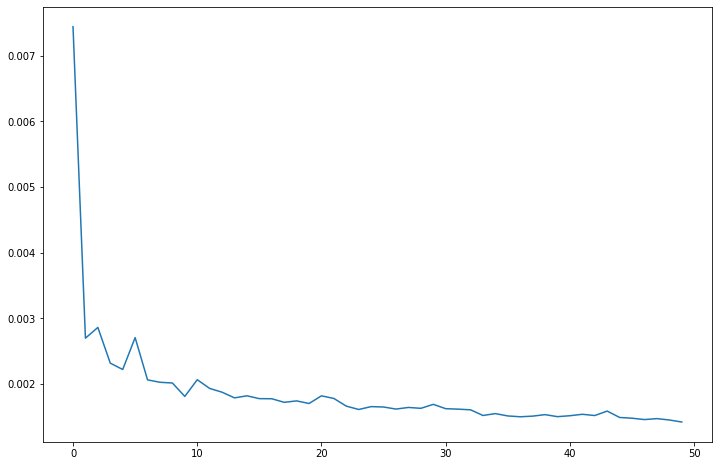

In [59]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(12,8))
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [77]:
### Test
last_train_batch = input_data[-(time_steps):]
print(last_train_batch)
last_train_batch = last_train_batch.reshape(1,time_steps,n_features)

[[0.96838003]
 [0.99767075]
 [1.        ]
 [0.96884581]
 [0.93641051]
 [0.93932211]
 [0.96133382]
 [0.96704063]
 [0.96581781]
 [0.93565364]
 [0.87363635]
 [0.87643156]
 [0.86431936]
 [0.90612994]]


In [92]:
preds = model.predict(last_train_batch)
preds = scaler.inverse_transform(preds)
preds

array([[287.59085, 285.92087, 287.09622, 286.38403, 285.6716 , 285.73828,
        285.95404]], dtype=float32)

In [83]:
last_batch_output = output_data[-1]
last_batch_output = scaler.inverse_transform(last_batch_output.reshape(-1,1))
last_batch_output

array([[289.1000061 ],
       [283.10998535],
       [288.76000977],
       [293.10998535],
       [294.8500061 ],
       [294.8500061 ],
       [294.23001099]])

RMSE of last train batch is 6.4801188471127515


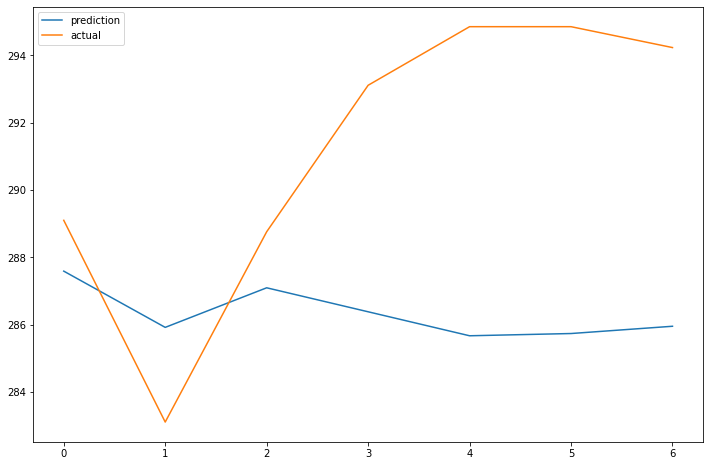

In [91]:
print(f'RMSE of last train batch is {mse(last_batch_output.flatten(), preds.flatten(), squared=False)}')

plt.figure(figsize=(12,8))
plt.plot(range(fcst_horizon), preds.flatten(), label='prediction')
plt.plot(range(fcst_horizon), last_batch_output.flatten(), label='actual')
plt.legend(['prediction','actual'])